In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from scipy.stats import bootstrap
import warnings
warnings.filterwarnings('ignore')

# Configuration
FILE_PATH = 'fixed_data.csv'
TARGET_COL = 'Download Speed Mbps'
FORECAST_HORIZON = 7
CONF_LEVEL = 0.95
N_BOOT = 10000
PLOT_START_DATE = '2024-11-01'
HOLD_OUT_PERIOD = 30


# Import Data and Choose the Largest 10

In [431]:

def load_and_preprocess():
    """Load and preprocess data with ISP-specific speeds"""
    df = pd.read_csv(FILE_PATH)
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter for median values
    df = df[df['metric_type'] == 'median']
    
    # Get top 10 ISPs by user count (adjust number as needed)
    isp_list = df[df['Provider Name'] != 'All Providers Combined']\
        .groupby('Provider Name')['User Count'].sum().nlargest(10).index.tolist()
    
    # Create wide format dataframe
    wide_df = df.pivot_table(
        index='date', 
        columns='Provider Name', 
        values=[TARGET_COL, 'Upload Speed Mbps']
    )
    wide_df.columns = [f"{col[1]}_{col[0].replace(' ', '_')}" for col in wide_df.columns]
    wide_df = wide_df.ffill().bfill()
    
    return wide_df, isp_list


In [432]:
wide_df, isp_list = load_and_preprocess()
target_cols = ["All Providers Combined_Download_Speed_Mbps"] + \
                [f"{isp}_{TARGET_COL.replace(' ', '_')}" for isp in isp_list]

In [433]:
wide_df[target_cols].corr()

,All Providers Combined_Download_Speed_Mbps,Baktelekom_Download_Speed_Mbps,Citynet_Download_Speed_Mbps,Aztelekom_Download_Speed_Mbps,KATV 1_Download_Speed_Mbps,Azeronline_Download_Speed_Mbps,EngiNet_Download_Speed_Mbps,Delta Telecom_Download_Speed_Mbps,Caspian Telecom_Download_Speed_Mbps,Selnet_Download_Speed_Mbps,GSP_Download_Speed_Mbps
All Providers Combined_Download_Speed_Mbps,1.000000,0.713599,0.793315,0.536159,0.739076,0.827997,0.388417,0.298969,0.557695,0.815602,0.112311
Baktelekom_Download_Speed_Mbps,0.713599,1.000000,0.448374,0.377764,0.544854,0.576557,0.320231,0.243851,0.305825,0.563736,0.042224
Citynet_Download_Speed_Mbps,0.793315,0.448374,1.000000,0.271408,0.522370,0.648090,0.295900,0.102519,0.423433,0.779475,0.087092
Aztelekom_Download_Speed_Mbps,0.536159,0.377764,0.271408,1.000000,0.292215,0.392601,0.170653,0.107799,0.248793,0.375150,0.064857
KATV 1_Download_Speed_Mbps,0.739076,0.544854,0.522370,0.292215,1.000000,0.628396,0.289074,0.319778,0.458230,0.629498,0.163224
Azeronline_Download_Speed_Mbps,0.827997,0.576557,0.648090,0.392601,0.628396,1.000000,0.238749,0.299181,0.454333,0.669442,-0.019988
EngiNet_Download_Speed_Mbps,0.388417,0.320231,0.295900,0.170653,0.289074,0.238749,1.000000,0.069087,0.243606,0.313925,0.058963
Delta Telecom_Download_Speed_Mbps,0.298969,0.243851,0.102519,0.107799,0.319778,0.299181,0.069087,1.000000,0.163385,0.175570,-0.013631
Caspian Telecom_Download_Speed_Mbps,0.557695,0.305825,0.423433,0.248793,0.458230,0.454333,0.243606,0.163385,1.000000,0.412316,0.049436
Selnet_Download_Speed_Mbps,0.815602,0.563736,0.779475,0.375150,0.629498,0.669442,0.313925,0.175570,0.412316,1.000000,0.100056


# Check Stationarity

In [434]:
def make_stationary(df, target_cols):
    """Apply first differences to target columns and test stationarity"""
    # Apply first difference to each target column
    stationary_df = df.copy()[target_cols]
    for col in target_cols:
        stationary_df[col] = df[col].diff()
    
    stationary_df = stationary_df.dropna()

    # ADF test for stationarity
    for col in target_cols:
        series = stationary_df[col]
        if series.nunique() <= 1:
            print(f"[SKIP] Column '{col}' is constant or all NaN after differencing. Skipping ADF test.")
            continue
        try:
            result = adfuller(series, maxlag=10)
            print(f"ADF Statistic ({col}): {result[0]:.4f}")
            print(f"p-value: {result[1]:.4f}")
            if result[1] > 0.05:
                print(f"Warning: {col} may still be non-stationary")
        except Exception as e:
            print(f"[ERROR] ADF test failed for column '{col}': {e}")
    
    return stationary_df

In [435]:
stationary_df = make_stationary(wide_df, target_cols)

ADF Statistic (All Providers Combined_Download_Speed_Mbps): -8.1084
p-value: 0.0000
ADF Statistic (Baktelekom_Download_Speed_Mbps): -7.4582
p-value: 0.0000
ADF Statistic (Citynet_Download_Speed_Mbps): -8.5323
p-value: 0.0000
ADF Statistic (Aztelekom_Download_Speed_Mbps): -9.7074
p-value: 0.0000
ADF Statistic (KATV 1_Download_Speed_Mbps): -7.4798
p-value: 0.0000
ADF Statistic (Azeronline_Download_Speed_Mbps): -6.8799
p-value: 0.0000
ADF Statistic (EngiNet_Download_Speed_Mbps): -9.2143
p-value: 0.0000
ADF Statistic (Delta Telecom_Download_Speed_Mbps): -7.8757
p-value: 0.0000
ADF Statistic (Caspian Telecom_Download_Speed_Mbps): -8.8285
p-value: 0.0000
ADF Statistic (Selnet_Download_Speed_Mbps): -6.3241
p-value: 0.0000
ADF Statistic (GSP_Download_Speed_Mbps): -10.8854
p-value: 0.0000


In [436]:
stationary_df

,All Providers Combined_Download_Speed_Mbps,Baktelekom_Download_Speed_Mbps,Citynet_Download_Speed_Mbps,Aztelekom_Download_Speed_Mbps,KATV 1_Download_Speed_Mbps,Azeronline_Download_Speed_Mbps,EngiNet_Download_Speed_Mbps,Delta Telecom_Download_Speed_Mbps,Caspian Telecom_Download_Speed_Mbps,Selnet_Download_Speed_Mbps,GSP_Download_Speed_Mbps
date,,,,,,,,,,,
2024-10-29,-0.50,4.20,2.65,3.17,3.80,-5.66,0.05,-0.80,3.97,-3.64,-4.25
2024-10-30,2.64,0.95,2.33,3.24,-4.23,5.95,8.52,-2.23,-3.55,3.72,5.09
2024-10-31,-7.17,-5.54,-3.70,-26.73,2.37,-23.31,-8.46,2.02,-4.22,-1.92,7.64
2024-11-01,-0.02,-5.63,0.46,5.25,0.98,-0.37,-1.81,1.85,1.94,1.02,-8.50
2024-11-02,7.91,5.35,1.04,17.93,-2.42,36.07,0.81,-1.19,2.83,0.78,0.77
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,-4.58,5.14,-1.75,-0.82,-1.46,-5.30,-1.63,-2.53,3.49,8.62,-0.46
2025-04-01,-1.00,0.71,-1.23,8.90,1.84,-13.78,2.52,-0.43,-1.16,11.10,2.58
2025-04-02,-0.26,-5.63,0.51,-0.98,1.15,23.70,8.80,-1.74,7.63,-29.90,-7.68


# VAR Modeling

In [437]:
def var_modelling(stationary_df, isp_list):
    """Build and analyze VAR model"""
    # Select target variables
    target_cols = ["All Providers Combined_Download_Speed_Mbps"] + \
                 [f"{isp}_{TARGET_COL.replace(' ', '_')}" for isp in isp_list]
    
    # Split data
    train_size = int(len(stationary_df) * 0.8)
    train = stationary_df[target_cols].iloc[:train_size]
    test = stationary_df[target_cols].iloc[train_size:]
    
    # Determine optimal lag order
    model = VAR(train)
    n_obs = len(train)
    n_vars = len(target_cols)
    maxlags = min(15, (n_obs - 1) // n_vars, 7)
    if maxlags < 1:
        maxlags = 1
    print(f"Using maxlags={maxlags} for VAR order selection (n_obs={n_obs}, n_vars={n_vars})")
    lag_results = model.select_order(maxlags)
    optimal_lags = lag_results.aic
    
    print(f"\nOptimal lag order (AIC): {optimal_lags}")
    
    # Fit VAR model
    var_model = model.fit(optimal_lags, trend='c')  # 'c' = constant, 'ct' = constant + linear trend
    print("\nModel Summary:")
    print(var_model.summary())
    
    return var_model, train, test

In [438]:
# Build VAR model
var_model, train, test = var_modelling(stationary_df, isp_list)

Using maxlags=7 for VAR order selection (n_obs=126, n_vars=11)

Optimal lag order (AIC): 7

Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     21:17:44
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    51.6901
Nobs:                     119.000    HQIC:                   39.7890
Log likelihood:          -2882.71    FPE:                9.60176e+14
AIC:                      31.6524    Det(Omega_mle):     3.75179e+12
--------------------------------------------------------------------
Results for equation All Providers Combined_Download_Speed_Mbps
                                                   coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------------
const         

# Variance Decomposition

In [439]:
var_model.forecast_interval(train.values[-var_model.k_ar:], FORECAST_HORIZON, alpha=0.05)

(array([[  3.40886998,   2.78476289,  -4.39127877,   7.9726785 ,
          -3.42771047,  13.36301388,   2.13503845,  -0.59622765,
           1.82850198,  -2.74204744,   0.58229569],
        [ -7.55769365, -12.11273071,  -2.47405043,  -6.69077837,
          -4.5702719 , -15.56041921, -19.53974142,  -5.580116  ,
          18.89196388,   4.86116054, -10.74653146],
        [  5.08628428,  17.65894303,  10.07183771,  -8.49890219,
           4.62848899,   1.74427579,  16.48906589,   4.00498357,
         -15.89097914,   6.2135514 ,   6.74283621],
        [ -3.02993374,  -7.24664609,  -6.3282014 ,   6.74144973,
          -0.71012315,   3.22554848,   7.54442288,  -0.84214847,
          -5.07462716, -12.09833716,  -5.65008052],
        [  4.64095785,  -9.94361789,   3.45612891,   3.82368527,
           3.48827064,   2.33345327,  -5.94233824,   6.11550071,
          15.6883035 ,   5.7552979 ,  14.79775936],
        [ -0.32320679,  11.40113829,   1.24418515,  -3.83070006,
          -2.27808234,  -

In [440]:
def variance_decomposition(var_model, horizon=10):
    """Calculate and plot forecast error variance decomposition"""
    try:
        fevd = var_model.fevd(horizon)
        variable_idx = 0  # Index for All Providers Combined
        title = f'Variance Decomposition of {var_model.names[variable_idx]}'
        decomp_data = fevd.decomp[variable_idx]
        fevd_df = pd.DataFrame(
            decomp_data, 
            columns=var_model.names,
            index=[f"Step {i+1}" for i in range(horizon)]
        )

        fig, ax = plt.subplots(figsize=(14, 8))
        plt.subplots_adjust(right=0.75)
        fevd_df.plot(kind='area', stacked=True, colormap='tab20', alpha=0.85, ax=ax)
        plt.title(title, fontsize=16, pad=15)
        plt.ylabel('Proportion of Variance Explained', fontsize=14)
        plt.xlabel('Forecast Horizon (Steps Ahead)', fontsize=14)
        plt.ylim(0, 1.05)
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Reposition annotations to avoid overlap
        ax.annotate('At Step 1, 100% of variance is\nexplained by the combined providers', 
                   xy=(0, 0.95), 
                   xytext=(1.5, 0.95), 
                   xycoords='data',
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                   horizontalalignment='left', 
                   fontsize=11,
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))
        other_isp_contrib = 1 - fevd_df.iloc[-1, 0]
        ax.annotate(f'By Step {horizon}, individual ISPs\nexplain {other_isp_contrib:.1%} of variance', 
                   xy=(horizon-1, 0.4), 
                   xytext=(horizon-4, 0.4), 
                   xycoords='data',
                   arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                   horizontalalignment='center', 
                   fontsize=11,
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

        # Clean legend labels by removing '_Download_Speed_Mbps'
        handles, labels = ax.get_legend_handles_labels()
        cleaned_labels = [label.replace('_Download_Speed_Mbps', '') for label in labels]
        ax.legend(handles, cleaned_labels, 
                  title='ISP Contribution', 
                  loc='center left', 
                  bbox_to_anchor=(1.02, 0.5),
                  frameon=True,
                  fontsize=10)

        plt.savefig('variance_decomposition_improved.png', dpi=300, bbox_inches='tight')
        plt.show()

        final_step = fevd_df.iloc[-1].sort_values(ascending=False)
        print("\nTop ISP contributors to forecast variance at Step 10:")
        for isp, value in final_step.items():
            if value > 0.03:
                print(f"{isp.replace('_Download_Speed_Mbps', '')}: {value:.2%}")

        return fevd_df
    except Exception as e:
        print(f"Warning: Variance decomposition failed: {e}")
        print("Continuing with forecasting...")
        return None


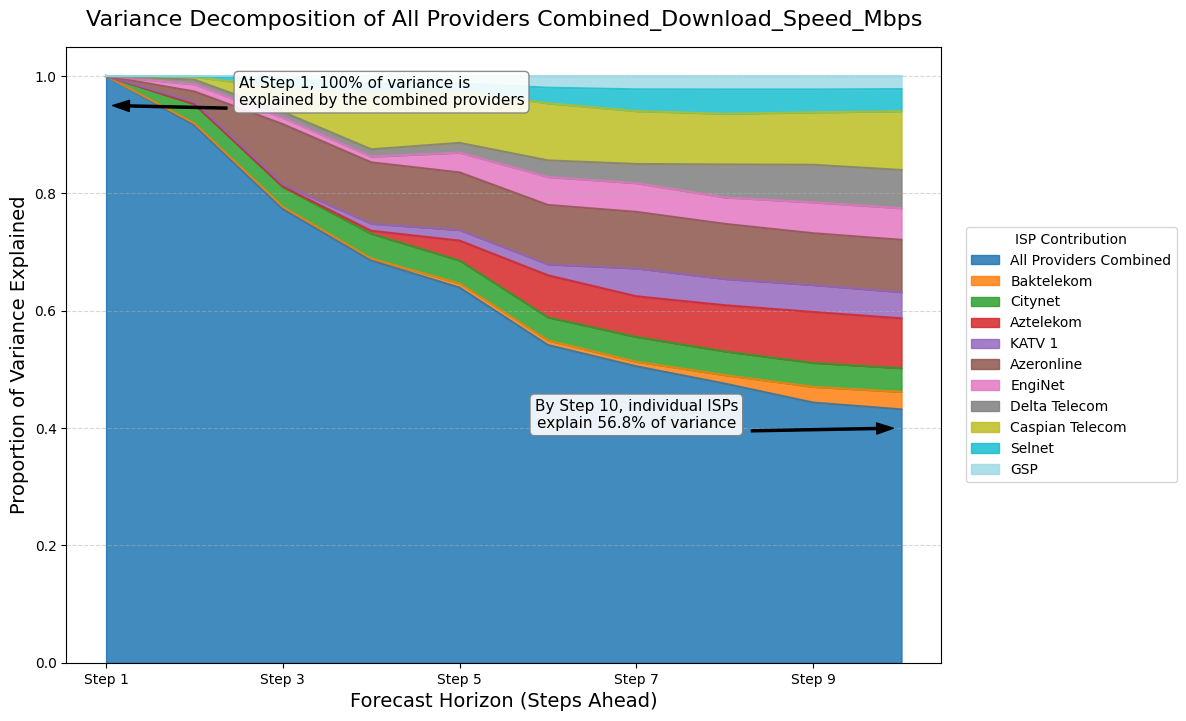


Top ISP contributors to forecast variance at Step 10:
All Providers Combined: 43.19%
Caspian Telecom: 10.01%
Azeronline: 8.92%
Aztelekom: 8.50%
Delta Telecom: 6.51%
EngiNet: 5.40%
KATV 1: 4.46%
Citynet: 4.03%
Selnet: 3.78%

Variance Decomposition Table:
         All Providers Combined_Download_Speed_Mbps  \
Step 1                                     1.000000   
Step 2                                     0.916082   
Step 3                                     0.773282   
Step 4                                     0.685614   
Step 5                                     0.639474   
Step 6                                     0.541576   
Step 7                                     0.505268   
Step 8                                     0.475798   
Step 9                                     0.443472   
Step 10                                    0.431854   

         Baktelekom_Download_Speed_Mbps  Citynet_Download_Speed_Mbps  \
Step 1                         0.000000                     0.00000

In [441]:
# Variance decomposition
fevd_df = variance_decomposition(var_model)
print("\nVariance Decomposition Table:")
print(fevd_df)

In [442]:
# Generate forecasts
lag_order = var_model.k_ar
forecast_steps = var_model.forecast(train.values[-lag_order:], FORECAST_HORIZON)

In [443]:
forecast_steps

array([[  3.40886998,   2.78476289,  -4.39127877,   7.9726785 ,
         -3.42771047,  13.36301388,   2.13503845,  -0.59622765,
          1.82850198,  -2.74204744,   0.58229569],
       [ -7.55769365, -12.11273071,  -2.47405043,  -6.69077837,
         -4.5702719 , -15.56041921, -19.53974142,  -5.580116  ,
         18.89196388,   4.86116054, -10.74653146],
       [  5.08628428,  17.65894303,  10.07183771,  -8.49890219,
          4.62848899,   1.74427579,  16.48906589,   4.00498357,
        -15.89097914,   6.2135514 ,   6.74283621],
       [ -3.02993374,  -7.24664609,  -6.3282014 ,   6.74144973,
         -0.71012315,   3.22554848,   7.54442288,  -0.84214847,
         -5.07462716, -12.09833716,  -5.65008052],
       [  4.64095785,  -9.94361789,   3.45612891,   3.82368527,
          3.48827064,   2.33345327,  -5.94233824,   6.11550071,
         15.6883035 ,   5.7552979 ,  14.79775936],
       [ -0.32320679,  11.40113829,   1.24418515,  -3.83070006,
         -2.27808234,  -4.16643457,  -4.1

In [444]:
forecast_steps

array([[  3.40886998,   2.78476289,  -4.39127877,   7.9726785 ,
         -3.42771047,  13.36301388,   2.13503845,  -0.59622765,
          1.82850198,  -2.74204744,   0.58229569],
       [ -7.55769365, -12.11273071,  -2.47405043,  -6.69077837,
         -4.5702719 , -15.56041921, -19.53974142,  -5.580116  ,
         18.89196388,   4.86116054, -10.74653146],
       [  5.08628428,  17.65894303,  10.07183771,  -8.49890219,
          4.62848899,   1.74427579,  16.48906589,   4.00498357,
        -15.89097914,   6.2135514 ,   6.74283621],
       [ -3.02993374,  -7.24664609,  -6.3282014 ,   6.74144973,
         -0.71012315,   3.22554848,   7.54442288,  -0.84214847,
         -5.07462716, -12.09833716,  -5.65008052],
       [  4.64095785,  -9.94361789,   3.45612891,   3.82368527,
          3.48827064,   2.33345327,  -5.94233824,   6.11550071,
         15.6883035 ,   5.7552979 ,  14.79775936],
       [ -0.32320679,  11.40113829,   1.24418515,  -3.83070006,
         -2.27808234,  -4.16643457,  -4.1

In [445]:
forecast_steps

array([[  3.40886998,   2.78476289,  -4.39127877,   7.9726785 ,
         -3.42771047,  13.36301388,   2.13503845,  -0.59622765,
          1.82850198,  -2.74204744,   0.58229569],
       [ -7.55769365, -12.11273071,  -2.47405043,  -6.69077837,
         -4.5702719 , -15.56041921, -19.53974142,  -5.580116  ,
         18.89196388,   4.86116054, -10.74653146],
       [  5.08628428,  17.65894303,  10.07183771,  -8.49890219,
          4.62848899,   1.74427579,  16.48906589,   4.00498357,
        -15.89097914,   6.2135514 ,   6.74283621],
       [ -3.02993374,  -7.24664609,  -6.3282014 ,   6.74144973,
         -0.71012315,   3.22554848,   7.54442288,  -0.84214847,
         -5.07462716, -12.09833716,  -5.65008052],
       [  4.64095785,  -9.94361789,   3.45612891,   3.82368527,
          3.48827064,   2.33345327,  -5.94233824,   6.11550071,
         15.6883035 ,   5.7552979 ,  14.79775936],
       [ -0.32320679,  11.40113829,   1.24418515,  -3.83070006,
         -2.27808234,  -4.16643457,  -4.1

# Bootstrap Confidence Interval

In [446]:
import numpy as np

def bootstrap_forecast_corrected(var_model, steps, n_boot=1000, conf_level=0.95):
    """Generate bootstrapped confidence intervals for VAR forecasts
    
    Parameters:
    var_model (VARResults): Fitted VAR model object
    steps (int): Forecast horizon
    n_boot (int): Number of bootstrap samples
    conf_level (float): Confidence level (0-1)
    
    Returns:
    tuple: (lower_bounds, upper_bounds) arrays of shape (steps, n_vars)
    """
    boot_samples = []
    resid_vals = var_model.resid.values
    n_resid = len(resid_vals)
    k_ar = var_model.k_ar
    last_obs = var_model.endog[-k_ar:].copy()
    n_vars = var_model.endog.shape[1]

    for _ in range(n_boot):
        # Sample residuals for each forecast step
        boot_resid_idx = np.random.choice(n_resid, size=steps, replace=True)
        boot_resid = resid_vals[boot_resid_idx]
        
        current_values = last_obs.copy()
        boot_pred = np.zeros((steps, n_vars))
        
        for i in range(steps):
            # Generate one-step forecast
            point_forecast = var_model.forecast(current_values, 1)[0]
            # Add bootstrapped residual
            boot_pred[i] = point_forecast + boot_resid[i]
            # Update lagged values for next iteration
            current_values = np.vstack([current_values[1:], boot_pred[i]])
        
        boot_samples.append(boot_pred)

    # Calculate confidence intervals
    boot_samples = np.array(boot_samples)
    lower = np.percentile(boot_samples, (1 - conf_level)/2 * 100, axis=0)
    upper = np.percentile(boot_samples, (1 + conf_level)/2 * 100, axis=0)
    
    return lower, upper


In [448]:

# Generate confidence intervals using bootstrap
lower, upper = bootstrap_forecast_corrected(var_model, steps=FORECAST_HORIZON, n_boot=N_BOOT, conf_level=CONF_LEVEL)

# Create forecast dataframe
dates = pd.date_range(
    start=wide_df.index[-1] + pd.Timedelta(days=1),
    periods=FORECAST_HORIZON,
    freq='D'
)

# Convert differenced forecasts back to levels
last_value = wide_df["All Providers Combined_Download_Speed_Mbps"].iloc[-1]
forecast_vals = [last_value]
lower_vals = [last_value]
upper_vals = [last_value]

for i in range(FORECAST_HORIZON):
    forecast_vals.append(forecast_vals[-1] + forecast_steps[i][0])
    lower_vals.append(lower_vals[-1] + lower[i][0])
    upper_vals.append(upper_vals[-1] + upper[i][0])

# Remove first value (it's the last observed value)
forecast_vals = forecast_vals[1:]
lower_vals = lower_vals[1:]
upper_vals = upper_vals[1:]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': dates,
    'forecast': forecast_vals,
    'lower': lower_vals,
    'upper': upper_vals
}).set_index('date')

# Save forecasts


# Plot Forecasts

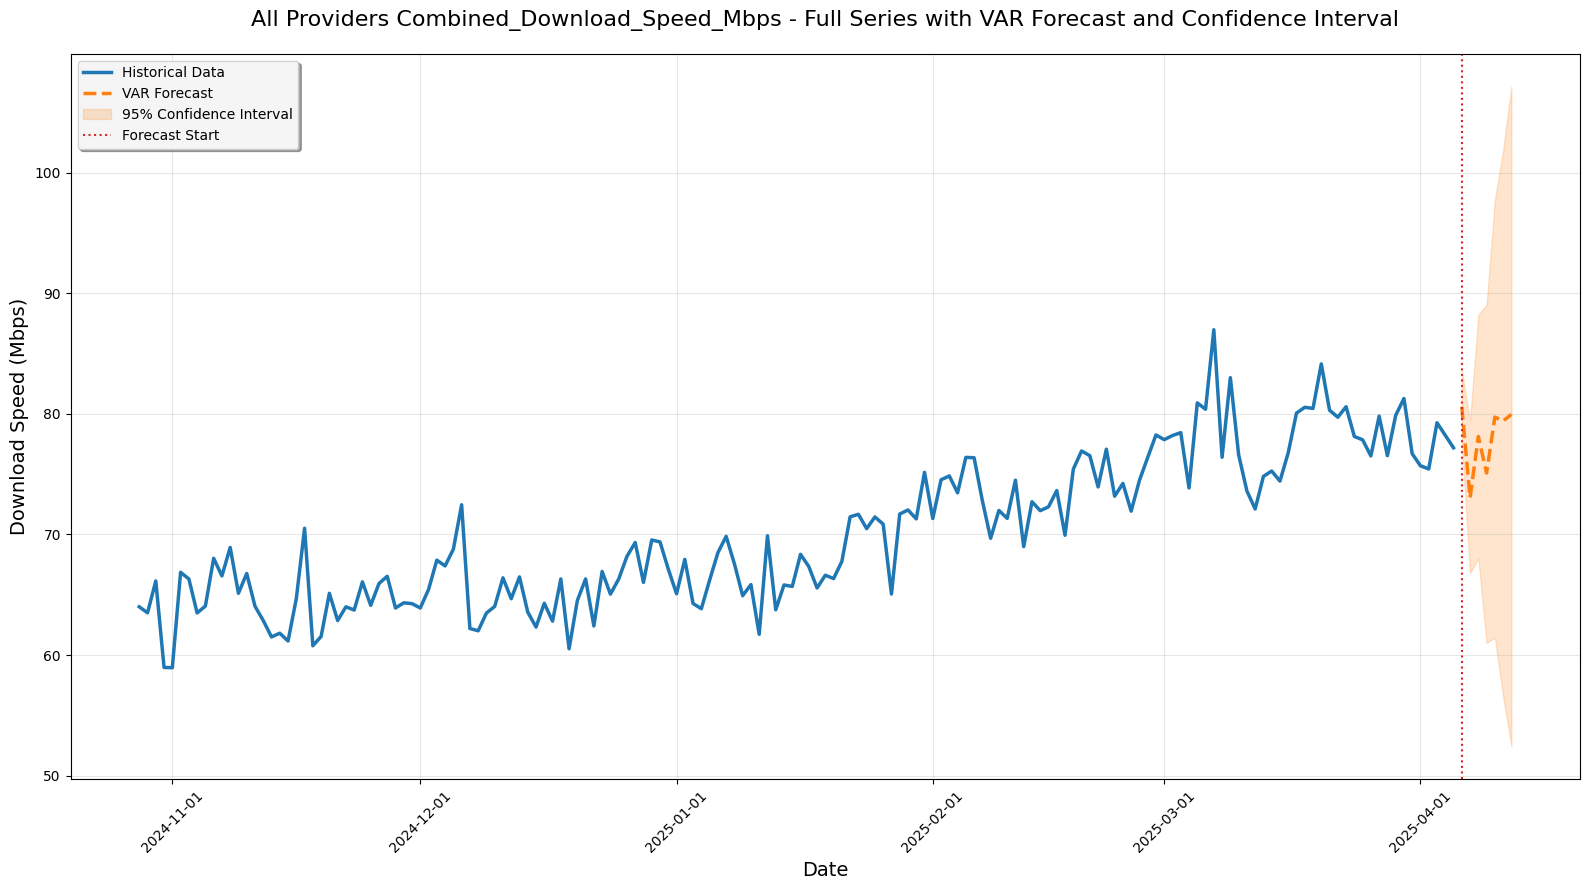

In [464]:
import matplotlib.pyplot as plt

def plot_full_series_with_forecast(
    wide_df, forecast_df, target_col, conf_level=0.95, forecast_label="VAR Forecast"
):
    """
    Plot the complete historical series and overlay the forecast with confidence intervals.

    Parameters:
    - wide_df: DataFrame with the full historical data (level), indexed by date.
    - forecast_df: DataFrame with forecast results (should have columns: 'forecast', 'lower', 'upper'), indexed by date.
    - target_col: str, name of the column in wide_df to plot as the historical series.
    - conf_level: float, confidence level for intervals (e.g., 0.95).
    - forecast_label: str, label for the forecast line.
    """
    plt.figure(figsize=(16, 9))

    # Plot complete historical series
    plt.plot(
        wide_df.index,
        wide_df[target_col],
        label="Historical Data",
        color="#1f77b4",
        linewidth=2.5,
    )

    # Overlay forecast
    plt.plot(
        forecast_df.index,
        forecast_df["forecast"],
        label=forecast_label,
        color="#ff7f0e",
        linewidth=2.5,
        linestyle="--",
    )

    # Confidence interval
    plt.fill_between(
        forecast_df.index,
        forecast_df["lower"],
        forecast_df["upper"],
        color="#ff7f0e",
        alpha=0.2,
        label=f"{conf_level*100:.0f}% Confidence Interval",
    )

    # Vertical line at forecast start
    plt.axvline(
        x=forecast_df.index[0],
        color="#d62728",
        linestyle=":",
        linewidth=1.5,
        label="Forecast Start",
    )

    plt.title(
        f"{target_col} - Full Series with VAR Forecast and Confidence Interval",
        fontsize=16,
        pad=20,
    )
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Download Speed (Mbps)", fontsize=14)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", frameon=True, framealpha=0.9, shadow=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("full_series_with_forecast.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_full_series_with_forecast(
    wide_df,
    forecast_df,
    target_col="All Providers Combined_Download_Speed_Mbps",  # or your actual column name
    conf_level=0.95,
    forecast_label="VAR Forecast",
)

# Holdout Sample Evaluation

In [450]:
def evaluate_model_on_holdout(wide_df, target_cols, holdout_periods=60):
    """Evaluate model performance on a holdout sample"""
    # Prepare differenced data
    stationary_df = make_stationary(wide_df, target_cols)
    
    # Split into training and holdout on stationary data
    train_size = len(stationary_df) - holdout_periods
    train_data = stationary_df.iloc[:train_size]
    holdout_data = stationary_df.iloc[train_size:]
    
    print(f"Training on {train_size} periods, holding out {len(holdout_data)} periods for validation")
    
    # Build model on training data only
    model = VAR(train_data[target_cols])
    n_obs = len(train_data)
    n_vars = len(target_cols)
    maxlags = min(15, (n_obs - 1) // n_vars, 7)
    if maxlags < 1:
        maxlags = 1
    print(f"Using maxlags={maxlags} for holdout validation")
    lag_results = model.select_order(maxlags)
    optimal_lags = lag_results.aic
    var_model = model.fit(optimal_lags, trend='c')  # 'c' = constant, 'ct' = constant + linear trend
    
    # Create forecasts (in differenced space)
    lag_order = var_model.k_ar
    forecasts = []
    dates = []
    for i in range(len(holdout_data)):
        if i == 0:
            last_values = train_data[target_cols].values[-lag_order:]
        else:
            last_values = np.vstack([last_values[1:], holdout_data[target_cols].values[i-1:i]])
        forecast = var_model.forecast(last_values, 1)
        forecasts.append(forecast[0][0])  # First variable
        dates.append(holdout_data.index[i])
    
    # --- FIX: Align indices for levels reconstruction ---
    # The first value for level reconstruction should be the last value of the training period in level data.
    # After differencing, stationary_df is shorter than wide_df by 1.
    # So, the last value in the training set (in level data) is at index: train_size + (len(wide_df) - len(stationary_df))
    level_offset = len(wide_df) - len(stationary_df)
    last_actual_value = wide_df[target_cols[0]].iloc[train_size + level_offset - 1]
    
    # Reconstruct forecast in level space
    forecasts_original = [last_actual_value]
    for i in range(len(forecasts)):
        forecasts_original.append(forecasts_original[-1] + forecasts[i])
    forecasts_original = forecasts_original[1:]  # Remove the initial value used for conversion

    # Get actual values directly from wide_df for the holdout period
    # The holdout period in wide_df starts at: train_size + level_offset
    actuals_original = wide_df[target_cols[0]].iloc[train_size + level_offset : train_size + level_offset + len(forecasts)].values
    
    # Combine into a DataFrame
    holdout_df = pd.DataFrame({
        'date': dates,
        'actual': actuals_original,
        'forecast': forecasts_original
    })
    holdout_df.set_index('date', inplace=True)
    
    # Calculate error metrics
    mae = np.mean(np.abs(holdout_df['actual'] - holdout_df['forecast']))
    rmse = np.sqrt(np.mean((holdout_df['actual'] - holdout_df['forecast'])**2))
    mape = np.mean(np.abs((holdout_df['actual'] - holdout_df['forecast']) / holdout_df['actual'])) * 100
    
    print(f"\nHoldout Validation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f} Mbps")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Mbps")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Plot the holdout results
    plt.figure(figsize=(16, 9))
    plt.plot(holdout_df.index, holdout_df['actual'], label='Actual Values', color='navy', linewidth=2.5)
    plt.plot(holdout_df.index, holdout_df['forecast'], label='VAR Forecasts', color='#ff7f0e', linewidth=2.5, linestyle='--')
    
    for i, (idx, row) in enumerate(holdout_df.iterrows()):
        plt.plot([idx, idx], [row['actual'], row['forecast']], color='red', alpha=0.3, linewidth=1)
    
    plt.title(f'Holdout Validation: {target_cols[0]} Forecast vs Actual', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Download Speed (Mbps)', fontsize=14)
    
    annotation = f"Model Performance Metrics:\n"
    annotation += f"MAE: {mae:.2f} Mbps\n"
    annotation += f"RMSE: {rmse:.2f} Mbps\n"
    annotation += f"MAPE: {mape:.2f}%"
    
    plt.annotate(annotation, xy=(0.02, 0.03), xycoords='axes fraction', fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    
    plt.legend(loc='upper left', frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('holdout_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return holdout_df, mae, rmse, mape

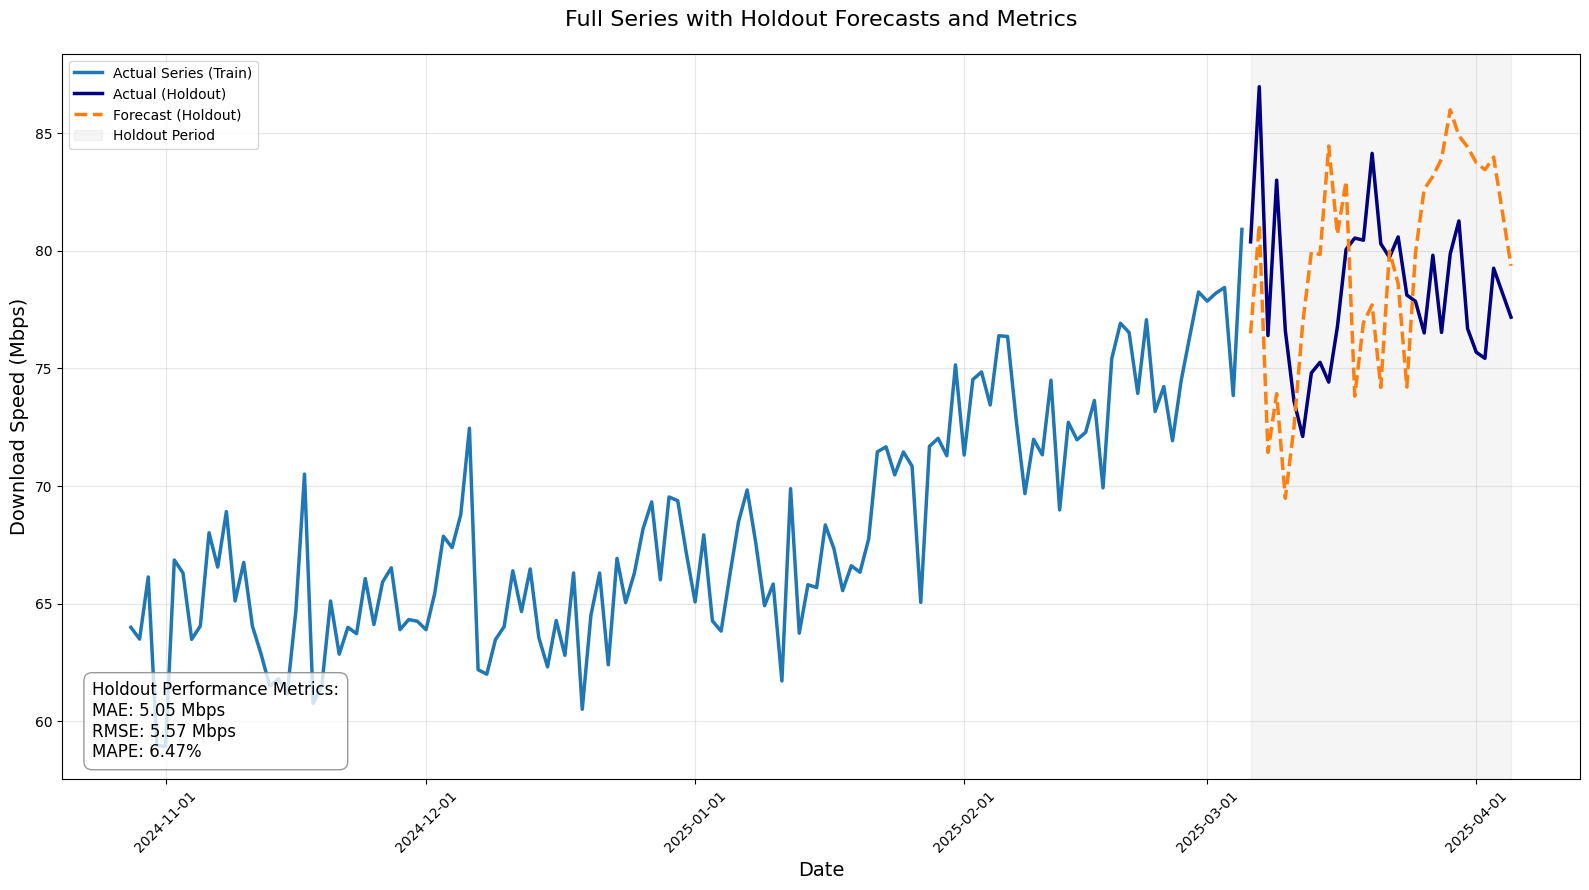

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [451]:
plot_holdout_with_confidence(wide_df, holdout_df, mae, rmse, mape) 

ADF Statistic (All Providers Combined_Download_Speed_Mbps): -8.1084
p-value: 0.0000
ADF Statistic (Baktelekom_Download_Speed_Mbps): -7.4582
p-value: 0.0000
ADF Statistic (Citynet_Download_Speed_Mbps): -8.5323
p-value: 0.0000
ADF Statistic (Aztelekom_Download_Speed_Mbps): -9.7074
p-value: 0.0000
ADF Statistic (KATV 1_Download_Speed_Mbps): -7.4798
p-value: 0.0000
ADF Statistic (Azeronline_Download_Speed_Mbps): -6.8799
p-value: 0.0000
ADF Statistic (EngiNet_Download_Speed_Mbps): -9.2143
p-value: 0.0000
ADF Statistic (Delta Telecom_Download_Speed_Mbps): -7.8757
p-value: 0.0000
ADF Statistic (Caspian Telecom_Download_Speed_Mbps): -8.8285
p-value: 0.0000
ADF Statistic (Selnet_Download_Speed_Mbps): -6.3241
p-value: 0.0000
ADF Statistic (GSP_Download_Speed_Mbps): -10.8854
p-value: 0.0000
Training on 128 periods, holding out 30 periods for validation
Using maxlags=7 for holdout validation

Holdout Validation Metrics:
Mean Absolute Error (MAE): 5.05 Mbps
Root Mean Squared Error (RMSE): 5.57 Mbps

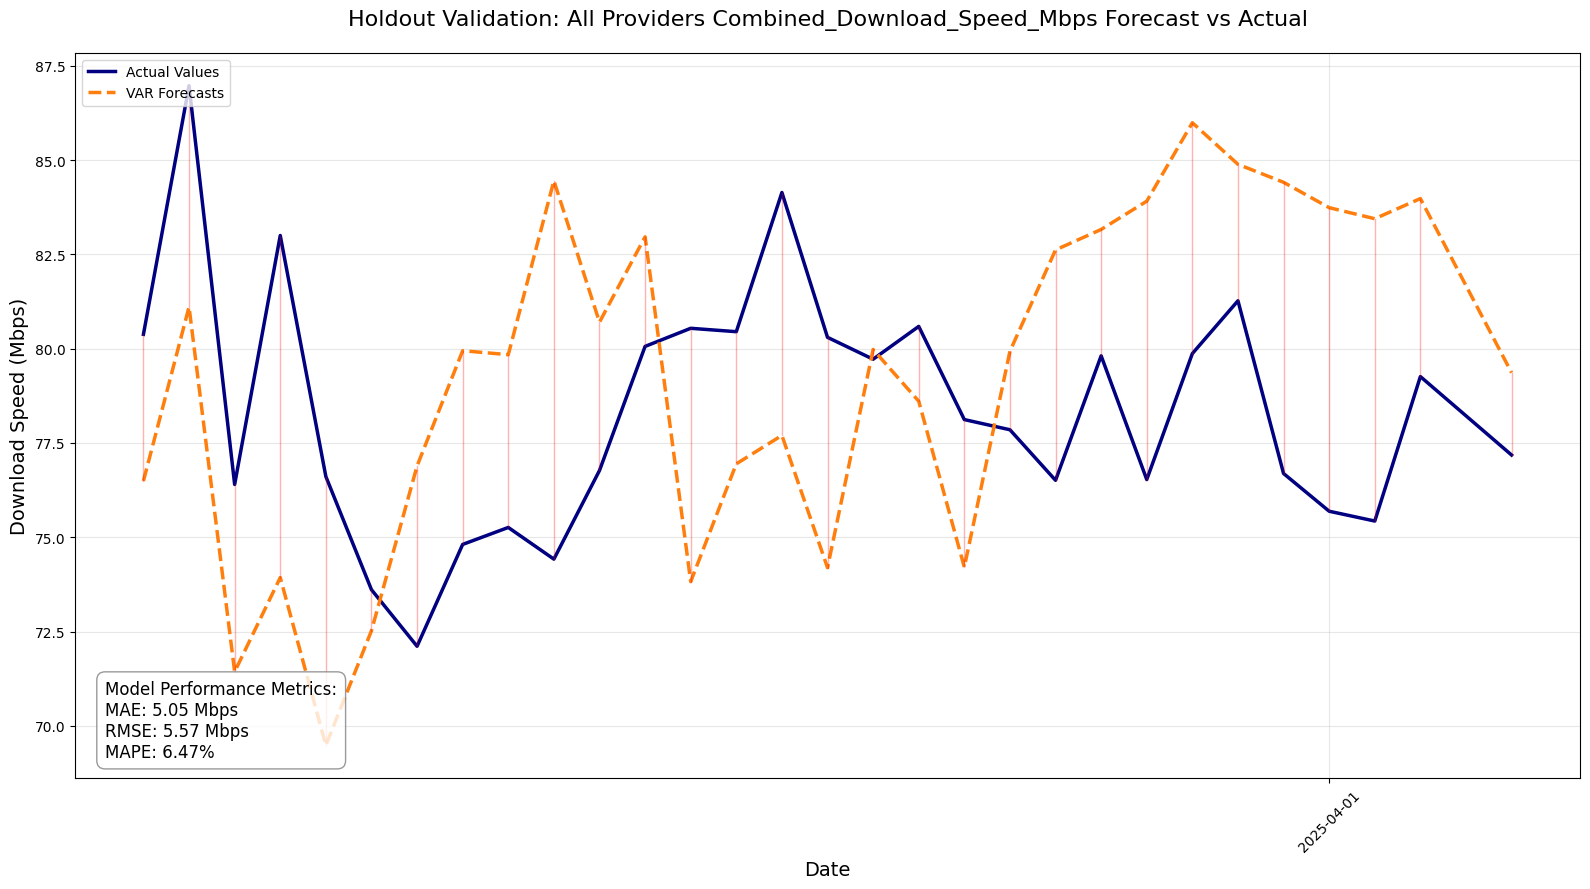

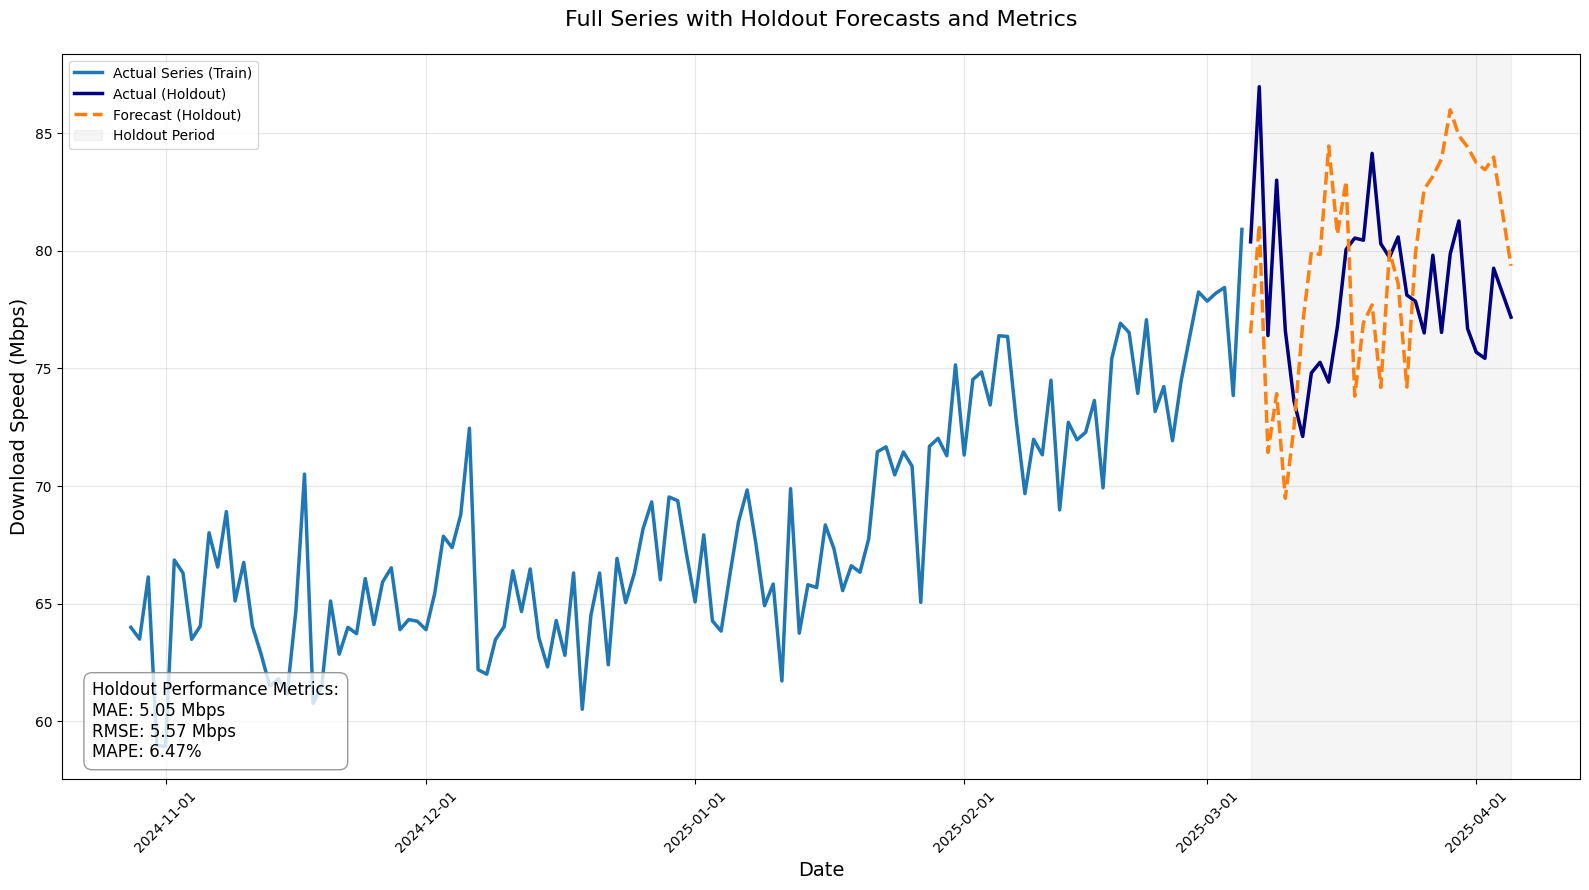

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [452]:

def plot_holdout_with_confidence(wide_df, holdout_df, mae, rmse, mape):
    """Plot the full series, overlay holdout predictions, and annotate with metrics."""
    import matplotlib.dates as mdates
    plt.figure(figsize=(16, 9))
    # Plot the actual series up to the start of the holdout period
    plt.plot(wide_df.index[:wide_df.index.get_loc(holdout_df.index[0])],
             wide_df["All Providers Combined_Download_Speed_Mbps"].iloc[:wide_df.index.get_loc(holdout_df.index[0])],
             label="Actual Series (Train)", color="#1f77b4", linewidth=2.5)
    # Plot the actuals only for the holdout period
    plt.plot(holdout_df.index, holdout_df["actual"], label="Actual (Holdout)", color="navy", linewidth=2.5)
    # Overlay holdout predictions
    plt.plot(holdout_df.index, holdout_df["forecast"], label="Forecast (Holdout)", color="#ff7f0e", linewidth=2.5, linestyle="--")
    # Optionally: Add confidence intervals if available (not implemented here, placeholder)
    # plt.fill_between(holdout_df.index, holdout_df["lower"], holdout_df["upper"], color="#ffbb78", alpha=0.3, label="Holdout 95% CI")

    plt.title("Full Series with Holdout Forecasts and Metrics", fontsize=16, pad=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Download Speed (Mbps)", fontsize=14)
    # Annotate metrics
    annotation = f"Holdout Performance Metrics:\nMAE: {mae:.2f} Mbps\nRMSE: {rmse:.2f} Mbps\nMAPE: {mape:.2f}%"
    plt.annotate(annotation, xy=(0.02, 0.03), xycoords='axes fraction', fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    # Highlight holdout region
    plt.axvspan(holdout_df.index[0], holdout_df.index[-1], color="gray", alpha=0.08, label="Holdout Period")
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('full_series_with_holdout_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()
    return plt.gcf()


holdout_df, mae, rmse, mape = evaluate_model_on_holdout(wide_df, target_cols, holdout_periods=HOLD_OUT_PERIOD)

# Plot the full series with holdout predictions and metrics
plot_holdout_with_confidence(wide_df, holdout_df, mae, rmse, mape)
